## Notebook to load catalog data, and perform the iteration

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import astropy.units as u
import gc
from astropy.coordinates import SkyCoord, GeocentricTrueEcliptic
from library.snr import optimal_snr
from library.lisa_psd import noise_psd_AE

/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Step 1: pre-process the catalog

In the terminal, run:

`python preprocess_catalog.py     --filepath filepath  
   --output output_filenam.h5     --T_obs T_obs      --delta_t deltat      --tdi 1.5 or 2.0     --snr_preselection snr_preselection      --batch_size bach_size `

/home/alice/catalog_binaries/catalogue_interaction_WDWD_processed.hdf5

default parameters: T_obs = 126144000 (4 years), delta_t = 5, tdi = 1.5, snr_preselection = 0.01, batch_size = 1000


In [2]:
from library.iteration_utils import load_waveforms, setup, run_iterative_separation

data = load_waveforms('binaries_all_SNR001_4yrs.h5')


In [3]:
snr_thr = 7
results_filename = 'results_all_snr7_4yrs'

T_obs = data['T_obs']

state = setup(data, snr_calculator= lambda source: optimal_snr(source["A"], source["psd_total"], T_obs=T_obs), psd_instrumental=noise_psd_AE, snr_threshold=snr_thr)
del data
gc.collect()


0

In [4]:
state['waveforms'].keys()

dict_keys(['A', 'E', 'fr', 'source_psd_estimate', 'f0', 'Ampl', 'with_wf', 'ecliptic_lat', 'ecliptic_lon', 'T_obs'])

In [5]:

results = run_iterative_separation(state,  max_iterations=50, filter_size=2000, print_progress=True, plot= False, save_results=True, output_file= results_filename)


Starting with 15539324 total sources
15173822 sources already pre-excluded and added to the confusion
365502 candidate sources to run the iteration
Frequency range: 1.75e-04 to 2.04e-02 Hz
SNR threshold: 7

--- Iteration 1 ---
  New resolved: 5080
  Still unresolved: 360422
  Total resolved: 5080

--- Iteration 2 ---
  New resolved: 26
  Still unresolved: 360396
  Total resolved: 5106

--- Iteration 3 ---
  New resolved: 0
  Still unresolved: 360396
  Total resolved: 5106

Converged after 3 iterations!

FINAL RESULTS:
  Total sources: 15539324
  Resolved: 5106 (0.0%)
  Unresolved: 15534218 (100.0%)

Saving resolved sources to results_all_snr7_4yrs...
Saved 5106 resolved sources to results_all_snr7_4yrs


Text(0, 0.5, 'PSD A')

/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


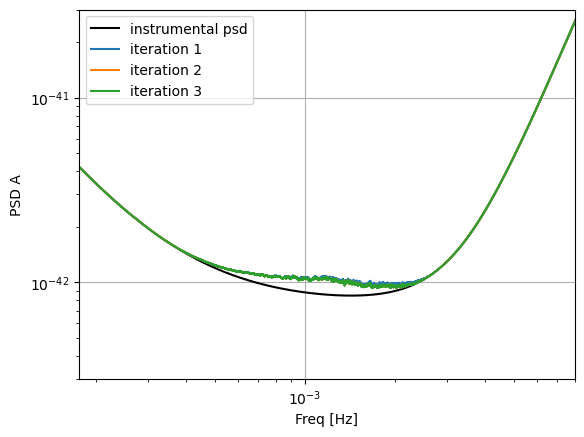

In [6]:
freqs = results['global_fr']
fig, ax = plt.subplots(1, 1)
ax.loglog(freqs, noise_psd_AE(freqs, tdi = 1.5), color='black', label = 'instrumental psd')
for i, psd in results['psd_confusion']:
    ax.loglog(freqs, psd, label=f"iteration {i}")
ax.set_xlim(freqs[0], 8e-3)
ax.set_ylim(3e-43, 3e-41)
ax.grid()
ax.legend()
ax.set_xlabel("Freq [Hz]")
ax.set_ylabel("PSD A")

In [7]:
print(results['resolved_sources'][0].keys())

dict_keys(['source', 'snr'])


In [8]:
source = results['resolved_sources'][0]['source'].keys()
print(source)

dict_keys(['f0', 'fr', 'A', 'psd_total', 'id', 'ecliptic_lon', 'ecliptic_lat'])
